In [1]:
# Libraries to work cross-platform
import os

# Libraries to work with dataset
import numpy as np
import pandas as pd
import ast                      # convert string to list after importing csv data

# Libraries to pre-process data
import nltk
from nltk.corpus import stopwords
import re
import string
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from rake_nltk import Rake
import spacy
from gensim.models.keyedvectors import KeyedVectors
# from cluster_visualization_helper import visualize_cluster, compute_cluster_visualization  # user-defined functions

# Libraries to visualize data
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries for monitoring operation process
from tqdm import tqdm

In [2]:
os_name = os.name

if os_name == 'nt':
    BASE_DIR = "E:/THIENDHB_GOOGLEDRIVE/MASTER TILBURG/THESIS/"
    INPUT_DIR = BASE_DIR + "DATASET/INPUT/"
    OUTPUT_DIR = BASE_DIR + "DATASET/OUTPUT/"
elif os_name == 'posix':
    BASE_DIR = "/media/pinkalinux/WORK/THIENDHB_GOOGLEDRIVE/MASTER TILBURG/THESIS/"
    INPUT_DIR = BASE_DIR + "DATASET/INPUT/"
    OUTPUT_DIR = BASE_DIR + "DATASET/OUTPUT/"

SEED = 6886

%matplotlib inline

In [3]:
df_raw = pd.read_csv(INPUT_DIR + "refined_jobpost_data.csv")
pd.set_option('display.max_colwidth', None)

In [4]:
skill_columns = ["job_description", "job_requirement", "job_qualification"]
skill_df = df_raw[skill_columns]
skill_df.head(2)

,job_description,job_requirement,job_qualification
0,"AMERIA Investment Consulting Company is seeking a\r\nChief Financial Officer. This position manages the company's fiscal and\r\nadministrative functions, provides highly responsible and technically\r\ncomplex staff assistance to the Executive Director. The work performed\r\nrequires a high level of technical proficiency in financial management\r\nand investment management, as well as management, supervisory, and\r\nadministrative skills.","- Supervises financial management and administrative staff, including\r\nassigning responsibilities, reviewing employees' work processes and\r\nproducts, counseling employees, giving performance evaluations, and\r\nrecommending disciplinary action;\r\n- Serves as member of management team participating in both strategic\r\nand operational planning for the company;\r\n- Directs and oversees the company's financial management activities,\r\nincluding establishing and monitoring internal controls, managing cash\r\nand investments, and managing the investment portfolio in collaboration\r\nwith the Investment team leader. This includes, but is not limited to,\r\nevaluation of investment risk, concentration risk, fund deployment\r\nlevels, adequacy of loss and liquidity reserves Assists investment team\r\nin development of proper documentation and internal systems;\r\n- Directs and oversees the annual budgeting process, including\r\ndeveloping projections for financial planning, and preparing budgets;\r\n- Prepares external and internal financial management reports, such as\r\naudited financial statements, tax returns, and reports for the board of\r\ndirectors and company staff;\r\n- Develops, implements, and maintains efficient and effective accounting\r\nsystems and controls to ensure compliance with national and\r\ninternational accounting standards and principles, sufficiency of fund\r\naccounting, and comprehensiveness of data for reporting and compliance\r\nrequirements;\r\n- Ensures contract compliance, including interpreting and monitoring\r\ncontracts with clients, submitting required reports, and monitoring\r\ncovenants and other contract terms;\r\n- Oversees the design, implementation and maintenance of computer-based\r\ninformation system. Oversees records retention (both manual and\r\ncomputer-based) and file maintenance activities;\r\n- Serves as company's risk manager, including evaluating loss exposure\r\nand obtaining insurance as appropriate;\r\n- Manages other administrative operations, such as facilities\r\nmanagement, payroll administration, office operations, and\r\nadministrative support;\r\n- Monitors corporate compliance with by-laws and articles of\r\nincorporation regarding corporate registration and reporting of\r\nfundraising operations.","To perform this job successfully, an\r\nindividual must be able to perform each essential duty satisfactorily.\r\nThe requirements listed below are representative of the knowledge,\r\nskill, and/or ability required.\r\nKnowledge of:\r\n- Generally accepted accounting principles;\r\n- Local accounting standards and legislation;\r\n- State reporting requirements pertaining to accounting;\r\n- Principles and practices of financial management and budgeting;\r\n- Principles and practices of financial systems design and analysis;\r\n- Principles and practices of contract management, records management,\r\nand risk management;\r\n- Principles and practices of management and supervision;\r\n- Principles and practices of information systems management.\r\nAbility to:\r\n- Apply sound fiscal and administrative practices to the company's\r\nactivities;\r\n- Plan, organize and supervise the work of subordinate employees,\r\nincluding training them, assigning and evaluating their work, and\r\nproviding job performance feedback;\r\n- Critically analyze fiscal and administrative policies, practices,\r\nprocedures, and systems, and recommend and implement changes as needed;\r\n- Gather and synthe

In [5]:
def nltk_tag_to_wordnet_tag(nltk_tag):
    """Helper function to convert nltk POS tags to wordnet POS tags"""
    if nltk_tag.startswith("J"):
        return wordnet.ADJ
    elif nltk_tag.startswith("V"):
        return wordnet.VERB
    elif nltk_tag.startswith("N"):
        return wordnet.NOUN
    elif nltk_tag.startswith("R"):
        return wordnet.ADV
    else:
        return wordnet.NOUN


def lemmatize_token(token):
    lemmatizer = WordNetLemmatizer()
    nltk_tagged = nltk.pos_tag(token)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            # if no tag found then use as it is
            lemmatized_sentence.append(word)
        else:
            # else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))

    return " ".join(lemmatized_sentence)


class pre_process_text:
    """Function to pre process text once for all steps:
    - Replace all consecutive special characters by 1 single character "|"
    - Removing URLs
    - Removing stop words
    - Removing special characters and numbers and replace by 1 space
    - Removing short words with length < 2
    - Lowercasing
    - Lemmatizing

    Inputs:
    - text: raw text to normalize
    - spec_chars: list of special characters to remove
    - stop_words: set of stopwords to remove

    Return: normalized text
    """

    def __init__(self, text, spec_chars, stop_words):
        self.text = text
        self.spec_chars = spec_chars
        self.stop_words = stop_words

    def convert2string(self):
        self.text = str(self.text)
        return self

    def lowercase(self):
        # convert to string and lowercasing
        self.text = self.text.lower()
        return self

    def remove_url(self):
        # remove URLs
        self.text = re.sub(r"http\S+", "", self.text)
        self.text = re.sub(r"www\S+", "", self.text)
        return self

    def remove_spec_chars(self):
        # remove special characters and numbers
        # self.text = self.text.translate(str.maketrans("", "", self.spec_chars))
        for char in self.spec_chars:
            self.text = self.text.replace(char, " ")
        self.text = re.sub("[ ]{2,}", " ", self.text)
        return self

    def replace_spec_chars(self):
        # replace special characters and numbers by "|"
        for char in self.spec_chars:
            self.text = self.text.replace(char, "|")
        self.text = re.sub("[|]{2,}", "|", self.text)
        return self

    def get_tokens(self):
        # tokenize
        self.text = nltk.word_tokenize(self.text)
        return self

    def join_phrases(self):
        # join keyphrases into 1 document
        self.text = [word for phrase in self.text for word in phrase.split()]
        return self

    def remove_stopwords(self):
        # remove stop words
        self.text = [word for word in self.text if word not in self.stop_words]
        self.text = " ".join(self.text)
        return self

    def remove_shortwords(self):
        # remove words with length < 2
        self.text = [word for word in self.text if len(word) >= 2]
        return self

    def lemmatize(self):
        # lemmatize
        self.text = lemmatize_token(self.text)
        return self

    def clean(self):
        self = self.convert2string()
        self = self.lowercase()
        self = self.remove_url()
        self = self.replace_spec_chars()
        return self

    def extract_keyphrases(self):
        # extract keyphrases
        rake_nltk_var = Rake(
            stopwords=self.stop_words,
            punctuations=self.spec_chars,
            min_length=1,
            max_length=2,
        )
        rake_nltk_var.extract_keywords_from_text(self.text)
        self.text = rake_nltk_var.get_ranked_phrases()[:20]
        return self.text

    def normalize(self):
        self = self.join_phrases()
        self = self.remove_stopwords()
        self = self.remove_spec_chars()
        self = self.get_tokens()
        self = self.remove_shortwords()
        self = self.lemmatize()
        self = self.get_tokens()
        return self.text

In [6]:
# Set stopwords and special characters to remove
stop_words = set(stopwords.words("english"))
spec_chars = string.punctuation + string.digits + "\n\r"

In [7]:
tqdm.pandas(desc="Job Skill Keyphrase extracting")
clean_skill_df = skill_df.progress_applymap(
    lambda x: pre_process_text(x, spec_chars=spec_chars, stop_words=stop_words)
    .clean()
    .extract_keyphrases()
)
clean_skill_df.head(3)

Job Skill Keyphrase extracting: 100%|██████████████████████████████████████████| 56976/56976 [00:14<00:00, 3956.53it/s]


,job_description,job_requirement,job_qualification
0,"[work performed, technical proficiency, position manages, high level, executive director, administrative skills, administrative functions, investment management, financial management, management, well, technically, supervisory, seeking, requires, fiscal, company]","[work processes, tax returns, risk manager, reviewing employees, proper documentation, preparing budgets, prepares external, payroll administration, operational planning, office operations, obtaining insurance, maintains efficient, investment risk, investment portfolio, information system, fundraising operations, financial planning, developing projections, counseling employees, contract terms]","[undergraduate degree, subordinate employees, strategic development, retaining high, requirements listed, prepare detailed, outstanding writing, operate ibm, masters degree, job successfully, individual must, implement changes, highly preferred, explanatory text, excellent leadership, excellent analytical, complex issues, administrative policies, risk management, records management]"
1,"[throughout armenia, community connections, willing, travel, program, position, paid, necessary, intern, fill, cc, based]","[vice versa, programmatic meetings, program staff, interested parties, helping create, cc staff, cc program, visitors, update, translation, scheduling, presenting, planning, participants, office, needed, maintain, interpretation, events, english]","[work independently, good communication, excellent skills, written english, past english, armenian translation, armenian languages, translation experience, english, armenian, experience, team, spoken, remuneration, preferred, part, master, degree, commensurate, bachelor]"
2,"[time position, primary contact, international organizations, environmental ngos, public outreach, public agencies, public, strengthening, serve, network, growing, full, cenn, businesses]","[international organizations, country director, caucasus region, armenian offices, armenian ngos, workshops, working, strategy, serving, policy, participating, organize, helping, defining, cenn, businesses, armenia, agencies, abroad]","[years relevant, written fluency, salary commensurate, working, russian, remuneration, plus, oral, knowledge, experience, english, degree, armenian, armenia]"


In [8]:
tqdm.pandas(desc="Job Skill Normalizing text")
skill_tokens_df = clean_skill_df.progress_applymap(
    lambda x: pre_process_text(x, spec_chars=spec_chars, stop_words=stop_words).normalize()
)
skill_tokens_df.head(3)

Job Skill Normalizing text: 100%|███████████████████████████████████████████████| 56976/56976 [01:50<00:00, 516.86it/s]


,job_description,job_requirement,job_qualification
0,"[work, perform, technical, proficiency, position, manage, high, level, executive, director, administrative, skill, administrative, function, investment, management, financial, management, management, well, technically, supervisory, seek, require, fiscal, company]","[work, process, tax, return, risk, manager, review, employee, proper, documentation, prepare, budget, prepare, external, payroll, administration, operational, planning, office, operation, obtain, insurance, maintains, efficient, investment, risk, investment, portfolio, information, system, fundraise, operation, financial, plan, develop, projection, counsel, employee, contract, term]","[undergraduate, degree, subordinate, employee, strategic, development, retain, high, requirement, list, prepare, detailed, outstanding, write, operate, ibm, master, degree, job, successfully, individual, must, implement, change, highly, preferred, explanatory, text, excellent, leadership, excellent, analytical, complex, issue, administrative, policy, risk, management, record, management]"
1,"[throughout, armenia, community, connection, willing, travel, program, position, pay, necessary, intern, fill, cc, base]","[vice, versa, programmatic, meeting, program, staff, interested, party, help, create, cc, staff, cc, program, visitor, update, translation, schedule, present, planning, participant, office, need, maintain, interpretation, event, english]","[work, independently, good, communication, excellent, skill, write, english, past, english, armenian, translation, armenian, languages, translation, experience, english, armenian, experience, team, speak, remuneration, preferred, part, master, degree, commensurate, bachelor]"
2,"[time, position, primary, contact, international, organization, environmental, ngos, public, outreach, public, agency, public, strengthen, serve, network, grow, full, cenn, business]","[international, organization, country, director, caucasus, region, armenian, office, armenian, ngos, workshop, work, strategy, serve, policy, participate, organize, help, define, cenn, business, armenia, agency, abroad]","[year, relevant, write, fluency, salary, commensurate, work, russian, remuneration, plus, oral, knowledge, experience, english, degree, armenian, armenia]"


In [9]:
clean_skill_df["skills"] = (
    clean_skill_df["job_description"]
    + clean_skill_df["job_requirement"]
    + clean_skill_df["job_qualification"]
)
clean_skill_df.head(3)

,job_description,job_requirement,job_qualification,skills
0,"[work performed, technical proficiency, position manages, high level, executive director, administrative skills, administrative functions, investment management, financial management, management, well, technically, supervisory, seeking, requires, fiscal, company]","[work processes, tax returns, risk manager, reviewing employees, proper documentation, preparing budgets, prepares external, payroll administration, operational planning, office operations, obtaining insurance, maintains efficient, investment risk, investment portfolio, information system, fundraising operations, financial planning, developing projections, counseling employees, contract terms]","[undergraduate degree, subordinate employees, strategic development, retaining high, requirements listed, prepare detailed, outstanding writing, operate ibm, masters degree, job successfully, individual must, implement changes, highly preferred, explanatory text, excellent leadership, excellent analytical, complex issues, administrative policies, risk management, records management]","[work performed, technical proficiency, position manages, high level, executive director, administrative skills, administrative functions, investment management, financial management, management, well, technically, supervisory, seeking, requires, fiscal, company, work processes, tax returns, risk manager, reviewing employees, proper documentation, preparing budgets, prepares external, payroll administration, operational planning, office operations, obtaining insurance, maintains efficient, investment risk, investment portfolio, information system, fundraising operations, financial planning, developing projections, counseling employees, contract terms, undergraduate degree, subordinate employees, strategic development, retaining high, requirements listed, prepare detailed, outstanding writing, operate ibm, masters degree, job successfully, individual must, implement changes, highly preferred, explanatory text, excellent leadership, excellent analytical, complex issues, administrative policies, risk management, records management]"
1,"[throughout armenia, community connections, willing, travel, program, position, paid, necessary, intern, fill, cc, based]","[vice versa, programmatic meetings, program staff, interested parties, helping create, cc staff, cc program, visitors, update, translation, scheduling, presenting, planning, participants, office, needed, maintain, interpretation, events, english]","[work independently, good communication, excellent skills, written english, past english, armenian translation, armenian languages, translation experience, english, armenian, experience, team, spoken, remuneration, preferred, part, master, degree, commensurate, bachelor]","[throughout armenia, community connections, willing, travel, program, position, paid, necessary, intern, fill, cc, based, vice versa, programmatic meetings, program staff, interested parties, helping create, cc staff, cc program, visitors, update, translation, scheduling, presenting, planning, participants, office, needed, maintain, interpretation, events, english, work independently, good communication, excellent skills, written english, past english, armenian translation, armenian languages, translation experience, english, armenian, experience, team, spoken, remuneration, preferred, part, master, degree, commensurate, bachelor]"
2,"[time position, primary contact, international organizations, environmental ngos, public outreach, public agencies, public, strengthening, serve, network, growing, full, cenn, businesses]","[international organizations, country director, caucasus region, armenian offices, armenian ngos, workshops, working, strategy, serving, policy, participating, organize, helping, defining, cenn, businesses, armenia, agencies, abroad]","[years relevant, written fluency, salary commensurate, working, russian, remuneration, plus, oral, knowledge, experience,

In [10]:
# Save cleaned job skills in file
clean_skill_df_outfile = OUTPUT_DIR + "clean_skill_df.csv"
clean_skill_df.to_csv(clean_skill_df_outfile, index=False)

In [11]:
skill_tokens_df["skills"] = (
    skill_tokens_df["job_description"]
    + skill_tokens_df["job_requirement"]
    + skill_tokens_df["job_qualification"]
)
skill_tokens_df.head(3)

,job_description,job_requirement,job_qualification,skills
0,"[work, perform, technical, proficiency, position, manage, high, level, executive, director, administrative, skill, administrative, function, investment, management, financial, management, management, well, technically, supervisory, seek, require, fiscal, company]","[work, process, tax, return, risk, manager, review, employee, proper, documentation, prepare, budget, prepare, external, payroll, administration, operational, planning, office, operation, obtain, insurance, maintains, efficient, investment, risk, investment, portfolio, information, system, fundraise, operation, financial, plan, develop, projection, counsel, employee, contract, term]","[undergraduate, degree, subordinate, employee, strategic, development, retain, high, requirement, list, prepare, detailed, outstanding, write, operate, ibm, master, degree, job, successfully, individual, must, implement, change, highly, preferred, explanatory, text, excellent, leadership, excellent, analytical, complex, issue, administrative, policy, risk, management, record, management]","[work, perform, technical, proficiency, position, manage, high, level, executive, director, administrative, skill, administrative, function, investment, management, financial, management, management, well, technically, supervisory, seek, require, fiscal, company, work, process, tax, return, risk, manager, review, employee, proper, documentation, prepare, budget, prepare, external, payroll, administration, operational, planning, office, operation, obtain, insurance, maintains, efficient, investment, risk, investment, portfolio, information, system, fundraise, operation, financial, plan, develop, projection, counsel, employee, contract, term, undergraduate, degree, subordinate, employee, strategic, development, retain, high, requirement, list, prepare, detailed, outstanding, write, operate, ibm, master, degree, job, successfully, individual, must, implement, change, highly, preferred, explanatory, text, excellent, leadership, excellent, analytical, complex, issue, ...]"
1,"[throughout, armenia, community, connection, willing, travel, program, position, pay, necessary, intern, fill, cc, base]","[vice, versa, programmatic, meeting, program, staff, interested, party, help, create, cc, staff, cc, program, visitor, update, translation, schedule, present, planning, participant, office, need, maintain, interpretation, event, english]","[work, independently, good, communication, excellent, skill, write, english, past, english, armenian, translation, armenian, languages, translation, experience, english, armenian, experience, team, speak, remuneration, preferred, part, master, degree, commensurate, bachelor]","[throughout, armenia, community, connection, willing, travel, program, position, pay, necessary, intern, fill, cc, base, vice, versa, programmatic, meeting, program, staff, interested, party, help, create, cc, staff, cc, program, visitor, update, translation, schedule, present, planning, participant, office, need, maintain, interpretation, event, english, work, independently, good, communication, excellent, skill, write, english, past, english, armenian, translation, armenian, languages, translation, experience, english, armenian, experience, team, speak, remuneration, preferred, part, master, degree, commensurate, bachelor]"
2,"[time, position, primary, contact, international, organization, environmental, ngos, public, outreach, public, agency, public, strengthen, serve, network, grow, full, cenn, business]","[international, organization, country, director, caucasus, region, armenian, office, armenian, ngos, workshop, work, strategy, serve, policy, participate, organize, help, define, cenn, business, armenia, agency, abroad]","[year, relevant, write, fluency, salary, commensurate, work, russian, remuneration, plus, oral, knowledge, experience, english, degree, armenian, armenia]","[time, position, primary, contact, international, organization, 

In [12]:
# Save cleaned job skill tokens in file
skill_tokens_df_outfile = OUTPUT_DIR + "skill_tokens_df.csv"
skill_tokens_df.to_csv(skill_tokens_df_outfile, index=False)

In [13]:
def create_vocab_list(df, col):
    vocab = []
    for doc in tqdm(df[col]):
        vocab.extend(doc)
    return vocab

In [14]:
skill_tokens_df = pd.read_csv(OUTPUT_DIR + "skill_tokens_df.csv")
skill_tokens_df = skill_tokens_df.applymap(ast.literal_eval)

In [15]:
tqdm.pandas(desc="Creating Job Skill Corpus")
full_vocab_list = create_vocab_list(skill_tokens_df, 'skills')

100%|████████████████████████████████████████████████████████████████████████| 18992/18992 [00:00<00:00, 431646.60it/s]


In [16]:
print(len(full_vocab_list))
full_vocab_list[:10]

1188202


['work',
 'perform',
 'technical',
 'proficiency',
 'position',
 'manage',
 'high',
 'level',
 'executive',
 'director']

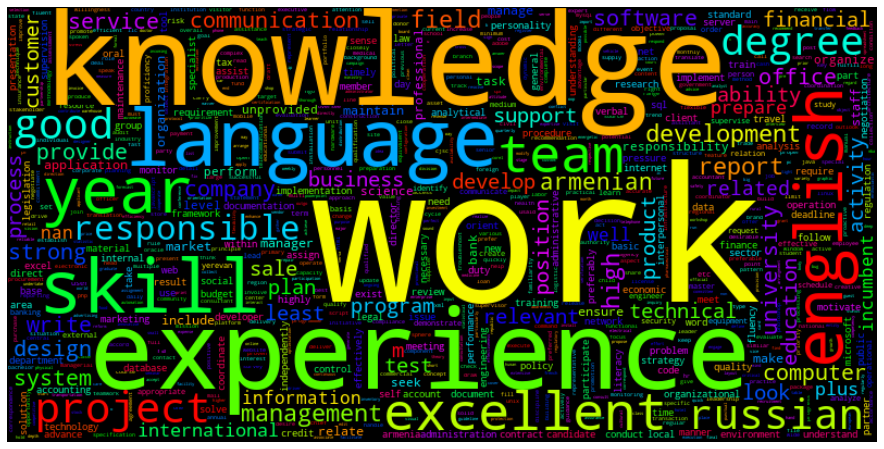

In [17]:
# Visualize the vocabulary list in Word Cloud

# Create a WordCloud object
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color="black",
    max_words=10000,
    #     min_font_size=9,
    #     max_font_size=80,
    prefer_horizontal=0.95,
    repeat=False,
    collocations=False,  # whether to include collocations (bigrams) of two words
    colormap=sns.color_palette("hsv", as_cmap=True),
    random_state=SEED,
)

# Generate a word cloud
wordcloud.generate(",".join(full_vocab_list))

# Visualize the word cloud
plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [18]:
vocab_list = list(set(full_vocab_list))
print(len(vocab_list))
vocab_list[:10]

13484


['flip',
 'optional',
 'pupil',
 'avenue',
 'watchfulness',
 'raoul',
 'newsroom',
 'syndication',
 'ssrs',
 'rehabilitation']

In [19]:
# load the pre-trained Stanford GloVe model in Word2Vec format (dimension 300)
pre_model = spacy.load('en_core_web_lg')

In [20]:
pre_model.pipe_names

['tok2vec', 'tagger', 'parser', 'ner', 'attribute_ruler', 'lemmatizer']

In [21]:
if 'parser' in pre_model.pipe_names:
    pre_model.remove_pipe('parser')
if 'ner' in pre_model.pipe_names:
    pre_model.remove_pipe('ner')
pre_model.pipe_names

['tok2vec', 'tagger', 'attribute_ruler', 'lemmatizer']

In [22]:
pre_model.max_length = 1500000

In [23]:
model_vocab = list(pre_model.vocab.strings)
type(model_vocab), len(model_vocab), model_vocab[:10]

(list,
 701570,
 ['\t', 'en', '\n', ' ', "'", "''", '"', "'Cause", 'because', "'cause"])

In [24]:
out_of_vocab = [token for token in vocab_list if token not in model_vocab]
print(len(out_of_vocab))
out_of_vocab[:10]

2076


['cantact',
 'hayanist',
 'armobil',
 'minfin',
 'developerment',
 'assisgned',
 'macadmian',
 'valti',
 'nonsql',
 'actr']

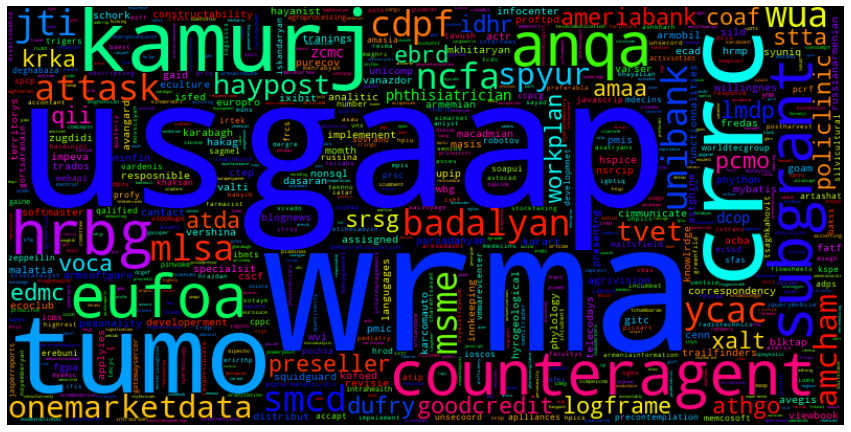

In [25]:
# Generate a word cloud
wordcloud.generate(",".join(out_of_vocab))

# Visualize the word cloud
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [26]:
# def create_corpus(df, col):

#     corpus = []
#     process_col = tqdm(df[col])
#     process_col.set_description(desc="Creating corpus")

#     for doc in process_col:
#         words = [word for word in nltk.word_tokenize(str(doc))]
#         corpus.append(words)

#     return corpus

In [27]:
skill_docs = skill_tokens_df['skills'].values.tolist()

In [28]:
len(skill_docs), len(skill_docs[0]), skill_docs[0][:10]

(18992,
 106,
 ['work',
  'perform',
  'technical',
  'proficiency',
  'position',
  'manage',
  'high',
  'level',
  'executive',
  'director'])

In [29]:
# Save cleaned job skill tokens in file
skill_docs_outfile = OUTPUT_DIR + "skill_docs.csv"
df = pd.DataFrame({"skill_tokens": []})
df["skill_tokens"] = skill_docs
df.to_csv(skill_docs_outfile, index=False)

In [30]:
# Extract word embeddings from Spacy model
vector_list = []
word_list = []
for token in tqdm(vocab_list):
    if token in model_vocab:
        word_emb = pre_model(token)
        vector_list.append(word_emb.vector)
        word_list.append(token)
    else:
        continue

100%|███████████████████████████████████████████████████████████████████████████| 13484/13484 [01:01<00:00, 217.55it/s]


In [31]:
# Store word embeddings in Gensim keyed vectors
kv = KeyedVectors(vector_size=len(vector_list[0]))
kv.add_vectors(keys=word_list, weights=vector_list)
kv.fill_norms(force=True)

In [32]:
# Save Gensim keyed vectors to file
kv.save(OUTPUT_DIR + 'skill_word_vectors.kv')

In [33]:
# Load Gensim keyed vectors from file
kv = KeyedVectors.load(OUTPUT_DIR + 'skill_word_vectors.kv')

In [34]:
normed_vectors = np.linalg.norm(kv.vectors, axis=1)

In [35]:
zero_normed_indexes = np.where(normed_vectors == 0)[0]

In [36]:
skill_docs_df = pd.read_csv(OUTPUT_DIR + "skill_docs.csv")
skill_docs_df["skill_tokens"] = skill_docs_df["skill_tokens"].apply(ast.literal_eval)
skill_docs = skill_docs_df["skill_tokens"].values.tolist()

In [37]:
sim_matrix = np.zeros((len(skill_docs), len(skill_docs)))
sim_matrix.shape

(18992, 18992)

In [38]:
start_list = [0]
start_list.extend(list(range(100, 19000, 200)))
len(start_list)

96

In [39]:
stop_list = list(range(100, 19000, 200))
stop_list.append(len(skill_docs))
# stop_list.append(18992)
len(stop_list)

96

In [40]:
for i in range(len(start_list)):

    start = start_list[i]
    stop = stop_list[i]
    print(i, start, stop)

    pbar = tqdm(desc="Computing WMD matrix", total=(stop - start) ** 2)
    for id1, doc1 in enumerate(skill_docs[start:stop]):
        for id2, doc2 in enumerate(skill_docs[start:stop]):
            #         print(start+id1, start+id2)
            if id1 == id2:
                sim_matrix[start + id1, start + id2] = 0
            elif id1 > id2:
                sim_matrix[start + id1, start + id2] = sim_matrix[start + id2, start + id1]
            else:
                # Calculate Word Mover's Distance between 2 documents
                sim_matrix[start + id1, start + id2] = kv.wmdistance(doc1, doc2, norm=False)
            pbar.update(1)
    pbar.close()

Computing WMD matrix:   0%|                                                          | 3/10000 [00:00<08:25, 19.77it/s]

0 0 100


Computing WMD matrix:   0%|                                                          | 5/40000 [00:00<16:02, 41.54it/s]

1 100 300


Computing WMD matrix:   0%|                                                          | 2/40000 [00:00<33:57, 19.63it/s]

2 300 500


Computing WMD matrix:   0%|                                                          | 9/40000 [00:00<08:29, 78.54it/s]

3 500 700


Computing WMD matrix:   0%|                                                          | 7/40000 [00:00<10:47, 61.73it/s]

4 700 900


Computing WMD matrix:   0%|                                                          | 4/40000 [00:00<16:46, 39.75it/s]

5 900 1100


Computing WMD matrix:   0%|                                                          | 6/40000 [00:00<12:10, 54.72it/s]

6 1100 1300


Computing WMD matrix:   0%|                                                          | 4/40000 [00:00<17:58, 37.10it/s]

7 1300 1500


Computing WMD matrix:   0%|                                                          | 8/40000 [00:00<09:20, 71.41it/s]

8 1500 1700


Computing WMD matrix:   0%|                                                          | 5/40000 [00:00<16:23, 40.65it/s]

9 1700 1900


Computing WMD matrix:   0%|                                                          | 6/40000 [00:00<23:48, 28.00it/s]

10 1900 2100


Computing WMD matrix:   0%|                                                          | 3/40000 [00:00<23:10, 28.77it/s]

11 2100 2300


Computing WMD matrix:   0%|                                                          | 7/40000 [00:00<10:51, 61.40it/s]

12 2300 2500


Computing WMD matrix:   0%|                                                          | 4/40000 [00:00<30:06, 22.14it/s]

13 2500 2700


Computing WMD matrix:   0%|                                                          | 3/40000 [00:00<26:20, 25.31it/s]

14 2700 2900


Computing WMD matrix:   0%|                                                          | 5/40000 [00:00<14:04, 47.36it/s]

15 2900 3100


Computing WMD matrix:   0%|                                                          | 5/40000 [00:00<15:17, 43.58it/s]

16 3100 3300


Computing WMD matrix:   0%|                                                          | 5/40000 [00:00<16:16, 40.97it/s]

17 3300 3500


Computing WMD matrix:   0%|                                                          | 4/40000 [00:00<28:27, 23.43it/s]

18 3500 3700


Computing WMD matrix:   0%|                                                          | 3/40000 [00:00<32:31, 20.50it/s]

19 3700 3900


Computing WMD matrix:   0%|                                                          | 6/40000 [00:00<11:50, 56.29it/s]

20 3900 4100


Computing WMD matrix:   0%|                                                          | 7/40000 [00:00<09:56, 67.06it/s]

21 4100 4300


Computing WMD matrix:   0%|                                                          | 4/40000 [00:00<23:01, 28.95it/s]

22 4300 4500


Computing WMD matrix:   0%|                                                          | 5/40000 [00:00<13:20, 49.98it/s]

23 4500 4700


Computing WMD matrix:   0%|                                                          | 6/40000 [00:00<13:01, 51.17it/s]

24 4700 4900


Computing WMD matrix:   0%|                                                          | 3/40000 [00:00<29:47, 22.38it/s]

25 4900 5100


Computing WMD matrix:   0%|                                                         | 11/40000 [00:00<15:28, 43.05it/s]

26 5100 5300


Computing WMD matrix:   0%|                                                          | 4/40000 [00:00<18:17, 36.45it/s]

27 5300 5500


Computing WMD matrix:   0%|                                                          | 3/40000 [00:00<23:44, 28.07it/s]

28 5500 5700


Computing WMD matrix:   0%|                                                          | 3/40000 [00:00<27:53, 23.91it/s]

29 5700 5900


Computing WMD matrix:   0%|                                                         | 14/40000 [00:00<11:20, 58.76it/s]

30 5900 6100


Computing WMD matrix:   0%|                                                          | 3/40000 [00:00<26:33, 25.10it/s]

31 6100 6300


Computing WMD matrix:   0%|                                                          | 4/40000 [00:00<18:31, 35.99it/s]

32 6300 6500


Computing WMD matrix:   0%|                                                          | 3/40000 [00:00<30:05, 22.15it/s]

33 6500 6700


Computing WMD matrix:   0%|                                                          | 3/40000 [00:00<28:47, 23.16it/s]

34 6700 6900


Computing WMD matrix:   0%|                                                          | 3/40000 [00:00<33:23, 19.96it/s]

35 6900 7100


Computing WMD matrix:   0%|                                                          | 3/40000 [00:00<27:47, 23.99it/s]

36 7100 7300


Computing WMD matrix:   0%|                                                          | 3/40000 [00:00<32:42, 20.38it/s]

37 7300 7500


Computing WMD matrix:   0%|                                                          | 4/40000 [00:00<20:57, 31.80it/s]

38 7500 7700


Computing WMD matrix:   0%|                                                          | 5/40000 [00:00<16:13, 41.10it/s]

39 7700 7900


Computing WMD matrix:   0%|                                                          | 2/40000 [00:00<38:26, 17.34it/s]

40 7900 8100


Computing WMD matrix:   0%|                                                          | 3/40000 [00:00<23:33, 28.29it/s]

41 8100 8300


Computing WMD matrix:   0%|                                                          | 3/40000 [00:00<27:49, 23.95it/s]

42 8300 8500


Computing WMD matrix:   0%|                                                          | 4/40000 [00:00<19:21, 34.44it/s]

43 8500 8700


Computing WMD matrix:   0%|                                                          | 3/40000 [00:00<34:19, 19.42it/s]

44 8700 8900


Computing WMD matrix:   0%|                                                          | 4/40000 [00:00<26:00, 25.63it/s]

45 8900 9100


Computing WMD matrix:   0%|                                                          | 5/40000 [00:00<15:23, 43.32it/s]

46 9100 9300


Computing WMD matrix:   0%|                                                          | 4/40000 [00:00<21:47, 30.58it/s]

47 9300 9500


Computing WMD matrix:   0%|                                                          | 4/40000 [00:00<21:41, 30.73it/s]

48 9500 9700


Computing WMD matrix:   0%|                                                          | 4/40000 [00:00<20:20, 32.77it/s]

49 9700 9900


Computing WMD matrix:   0%|                                                          | 4/40000 [00:00<19:00, 35.08it/s]

50 9900 10100


Computing WMD matrix:   0%|                                                          | 5/40000 [00:00<15:17, 43.60it/s]

51 10100 10300


Computing WMD matrix:   0%|                                                          | 4/40000 [00:00<23:29, 28.38it/s]

52 10300 10500


Computing WMD matrix:   0%|                                                          | 4/40000 [00:00<16:49, 39.62it/s]

53 10500 10700


Computing WMD matrix:   0%|                                                          | 3/40000 [00:00<23:07, 28.83it/s]

54 10700 10900


Computing WMD matrix:   0%|                                                          | 4/40000 [00:00<18:22, 36.27it/s]

55 10900 11100


Computing WMD matrix:   0%|                                                          | 3/40000 [00:00<22:58, 29.02it/s]

56 11100 11300


Computing WMD matrix:   0%|                                                          | 2/40000 [00:00<34:24, 19.37it/s]

57 11300 11500


Computing WMD matrix:   0%|                                                          | 6/40000 [00:00<13:51, 48.11it/s]

58 11500 11700


Computing WMD matrix:   0%|                                                          | 3/40000 [00:00<28:37, 23.29it/s]

59 11700 11900


Computing WMD matrix:   0%|                                                          | 3/40000 [00:00<22:15, 29.94it/s]

60 11900 12100


Computing WMD matrix:   0%|                                                          | 3/40000 [00:00<29:25, 22.65it/s]

61 12100 12300


Computing WMD matrix:   0%|                                                          | 3/40000 [00:00<23:13, 28.71it/s]

62 12300 12500


Computing WMD matrix:   0%|                                                          | 3/40000 [00:00<34:29, 19.32it/s]

63 12500 12700


Computing WMD matrix:   0%|                                                          | 3/40000 [00:00<25:19, 26.33it/s]

64 12700 12900


Computing WMD matrix:   0%|                                                          | 4/40000 [00:00<18:57, 35.16it/s]

65 12900 13100


Computing WMD matrix:   0%|                                                          | 3/40000 [00:00<27:29, 24.25it/s]

66 13100 13300


Computing WMD matrix:   0%|                                                          | 6/40000 [00:00<11:18, 58.96it/s]

67 13300 13500


Computing WMD matrix:   0%|                                                          | 8/40000 [00:00<09:32, 69.86it/s]

68 13500 13700


Computing WMD matrix:   0%|                                                          | 3/40000 [00:00<27:06, 24.60it/s]

69 13700 13900


Computing WMD matrix:   0%|                                                          | 5/40000 [00:00<15:46, 42.28it/s]

70 13900 14100


Computing WMD matrix:   0%|                                                          | 4/40000 [00:00<21:51, 30.50it/s]

71 14100 14300


Computing WMD matrix:   0%|                                                          | 6/40000 [00:00<11:42, 56.97it/s]

72 14300 14500


Computing WMD matrix:   0%|                                                          | 6/40000 [00:00<12:29, 53.37it/s]

73 14500 14700


Computing WMD matrix:   0%|                                                          | 4/40000 [00:00<22:02, 30.24it/s]

74 14700 14900


Computing WMD matrix:   0%|                                                          | 3/40000 [00:00<35:45, 18.64it/s]

75 14900 15100


Computing WMD matrix:   0%|                                                          | 4/40000 [00:00<24:18, 27.41it/s]

76 15100 15300


Computing WMD matrix:   0%|                                                          | 3/40000 [00:00<33:53, 19.67it/s]

77 15300 15500


Computing WMD matrix:   0%|                                                          | 3/40000 [00:00<30:45, 21.67it/s]

78 15500 15700


Computing WMD matrix:   0%|                                                        | 12/40000 [00:00<06:01, 110.50it/s]

79 15700 15900


Computing WMD matrix:   0%|                                                          | 4/40000 [00:00<20:39, 32.27it/s]

80 15900 16100


Computing WMD matrix:   0%|                                                          | 4/40000 [00:00<20:04, 33.20it/s]

81 16100 16300


Computing WMD matrix:   0%|                                                          | 5/40000 [00:00<21:12, 31.43it/s]

82 16300 16500


Computing WMD matrix:   0%|                                                          | 7/40000 [00:00<11:54, 55.96it/s]

83 16500 16700


Computing WMD matrix:   0%|                                                          | 3/40000 [00:00<26:05, 25.55it/s]

84 16700 16900


Computing WMD matrix:   0%|                                                          | 3/40000 [00:00<22:32, 29.57it/s]

85 16900 17100


Computing WMD matrix:   0%|                                                          | 7/40000 [00:00<10:59, 60.66it/s]

86 17100 17300


Computing WMD matrix:   0%|                                                          | 4/40000 [00:00<20:59, 31.75it/s]

87 17300 17500


Computing WMD matrix:   0%|                                                          | 4/40000 [00:00<23:28, 28.39it/s]

88 17500 17700


Computing WMD matrix:   0%|                                                          | 3/40000 [00:00<25:25, 26.21it/s]

89 17700 17900


Computing WMD matrix:   0%|                                                          | 3/40000 [00:00<22:43, 29.34it/s]

90 17900 18100


Computing WMD matrix:   0%|                                                          | 3/40000 [00:00<25:50, 25.80it/s]

91 18100 18300


Computing WMD matrix:   0%|                                                          | 5/40000 [00:00<18:20, 36.34it/s]

92 18300 18500


Computing WMD matrix:   0%|                                                          | 8/40000 [00:00<08:35, 77.62it/s]

93 18500 18700


Computing WMD matrix:   0%|                                                          | 2/40000 [00:00<43:00, 15.50it/s]

94 18700 18900


Computing WMD matrix:   0%|                                                           | 3/8464 [00:00<06:10, 22.85it/s]

95 18900 18992


Computing WMD matrix: 100%|████████████████████████████████████████████████████████| 8464/8464 [03:35<00:00, 39.21it/s]


In [41]:
# Save the distance matrix to file
np.save(OUTPUT_DIR + "job-skills_wmd-sim-matrix.npy", sim_matrix)

In [42]:
# # Reduce dimensionality using t-SNE algorithm
# pca_datapoint, mds_datapoint, tsne_datapoint = compute_cluster_visualization(
#     sim_matrix[:100, :100],
#     pca=False,
#     mds=True,
#     tsne=True,
#     seed=SEED,
#     metric="precomputed",
# )

In [43]:
# %%time
# plot_title = f"Distance matrix visualization"
# palette = sns.color_palette("hls", as_cmap=True)
# colors = np.linspace(0.5, 1, 100)

# # Visualize clusters with PCA and t-SNE
# visualize_cluster(plot_title, (12,12), colors, palette, pca_datapoint, tsne_datapoint, mds_datapoint, pca=False, tsne=True, mds=True)

In [44]:
# from sklearn_extra.cluster import KMedoids

# km = KMedoids(n_clusters=10, random_state=SEED, metric='precomputed', init='k-medoids++').fit(
#     sim_matrix[:100, :100]
# )

In [45]:
# %%time
# plot_title = f"K-Medoids visualization"
# palette = sns.color_palette("hls", as_cmap=True)
# colors = km.labels_ / 10

# # Visualize clusters with PCA and t-SNE
# visualize_cluster(plot_title, (12,12), colors, palette, pca_datapoint, tsne_datapoint, mds_datapoint, pca=False, tsne=True, mds=True)